# Testing an implementation of a Vision Transformer on #P6 Stanford dog image dataset

In [1]:
### Imports

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
import PIL
import matplotlib.pyplot as plt
import os
from PIL import Image
import math
import shutil
import tensorflow as tf
import keras
import tensorflow_hub as hub

In [2]:
### Google Drive connection :

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### Loading data directly from url :

# Importing librairies :
import requests
import math
import tarfile
import shutil

# Creating folder :
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Downloading data :
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
if url.find('/'):
  file_name = url.rsplit('/', 1)[1]

r = requests.get(url, allow_redirects=True)
open(file_name, 'wb').write(r.content)

# Extracting data from tarfile :
download_path = os.path.join('/content', file_name)
archive_file_path = os.path.join(DATA_PATH, file_name)
shutil.move(download_path, archive_file_path)

with tarfile.open(archive_file_path, 'r') as file:
  file.extractall(DATA_PATH)

print("Data downloaded and extracted from archive.")
print("Saved to ", DATA_PATH)

IMAGE_FOLDER_PATH = os.path.join(DATA_PATH, 'Images')
print("IMAGE_FOLDER_PATH : ", IMAGE_FOLDER_PATH)

Data downloaded and extracted from archive.
Saved to  /content/data
IMAGE_FOLDER_PATH :  /content/data/Images


In [ ]:
### Preprocessing function from https://colab.research.google.com/github/sayakpaul/ViT-jax2tf/blob/main/classification.ipynb#scrollTo=HZZC3qJcLQyM

def preprocess_image(image):
    image = np.array(image)
    image_resized = tf.image.resize(image, (224, 224))
    image_resized = tf.cast(image_resized, tf.float32)
    image_resized = (image_resized - 127.5) / 127.5
    return tf.expand_dims(image_resized, 0).numpy()

In [ ]:
### Creating model : 

def get_model(
    handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1", 
    num_classes=5,
):
    hub_layer = hub.KerasLayer(handle, trainable=False, name="pretrained_FE")

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model

ViT_1 = get_model(num_classes=120)

In [ ]:
ViT_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pretrained_FE (KerasLayer)  (None, 384)               21665664  
                                                                 
 dense (Dense)               (None, 120)               46200     
                                                                 
Total params: 21,711,864
Trainable params: 46,200
Non-trainable params: 21,665,664
_________________________________________________________________


In [4]:
### Splitting data into train_set, validation_set and test_set :

# Proportions :
train_proportion = 0.8
test_proportion = 0.1
val_proportion = 0.1

# Creating new folders :
IMAGE_FOLDER_PATH = os.path.join(DATA_PATH, 'Images')

TRAIN_PATH = os.path.join(DATA_PATH, 'train')
os.makedirs(TRAIN_PATH, exist_ok=True)

TEST_PATH = os.path.join(DATA_PATH, 'test')
os.makedirs(TRAIN_PATH, exist_ok=True)

VALIDATION_PATH = os.path.join(DATA_PATH, 'validation')
os.makedirs(VALIDATION_PATH, exist_ok=True)

## Creation of counters :
train_size = 0
test_size = 0
val_size = 0
breed_counter = 0

### Creating splits :

print("Creating splits and saving images to train/test/val folders...")

for breed_folder in os.listdir(IMAGE_FOLDER_PATH): # loop over all unique-breed folders
    
    # Updating counter :
    breed_counter = breed_counter + 1
    
    # Saving related pathes :
    breed_path_original = os.path.join(IMAGE_FOLDER_PATH, breed_folder)
    breed_path_train = os.path.join(TRAIN_PATH, breed_folder)
    breed_path_test = os.path.join(TEST_PATH, breed_folder)
    breed_path_validation = os.path.join(VALIDATION_PATH, breed_folder)
    
    # Creating unique-breed folders in train, test and validation folders :
    os.makedirs(breed_path_train, exist_ok=True)
    os.makedirs(breed_path_test, exist_ok=True)
    os.makedirs(breed_path_validation, exist_ok=True)
    
    # List of all images for this breed :
    breed_images_list = os.listdir(breed_path_original)
    breed_number_of_images = len(breed_images_list)
    
    # Allocation of images indexes in train, test and validation sets :
    test_val_threshold = test_proportion
    val_train_threshold = test_val_threshold + val_proportion
    
    breed_list_test = breed_images_list[:math.ceil(test_val_threshold*breed_number_of_images)]
    breed_list_val = breed_images_list[math.ceil(test_val_threshold*breed_number_of_images):math.ceil(val_train_threshold*breed_number_of_images)]
    breed_list_train = breed_images_list[math.ceil(val_train_threshold*breed_number_of_images):]
    
    # Test to check if every image is allocated to data set :
    
    try:
        assert len(breed_list_test) + len(breed_list_val) + len(breed_list_train) == breed_number_of_images
    except AssertionError :
        print("Error : each image of the breed from folder ", breed_folder, " has not been allocated to train / test / val sets.")
        break
    
    # Allocation of images in the right folders :
    
    for image in breed_list_test:
        test_size = test_size + 1
        original_file_path = os.path.join(breed_path_original, image)
        copy_file_path = os.path.join(breed_path_test, image)
        shutil.copyfile(original_file_path, copy_file_path)
        
    for image in breed_list_val:
        val_size = val_size + 1
        original_file_path = os.path.join(breed_path_original, image)
        copy_file_path = os.path.join(breed_path_validation, image)
        shutil.copyfile(original_file_path, copy_file_path)
                        
    for image in breed_list_train:
        train_size = train_size + 1
        original_file_path = os.path.join(breed_path_original, image)
        copy_file_path = os.path.join(breed_path_train, image)
        shutil.copyfile(original_file_path, copy_file_path)
                        
print("Done.")

print("Number of classes (breeds) : ", breed_counter)
print("Train set size : ", train_size)
print("Validation set size : ", val_size)
print("Test set size : ", test_size)
    

Creating splits and saving images to train/test/val folders...
Done.
Number of classes (breeds) :  120
Train set size :  16418
Validation set size :  2052
Test set size :  2110


In [ ]:
### Batch generation :

from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.25,
                                   zoom_range=0.25,
                                   channel_shift_range=25,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    batch_size=batch_size,
                                                    target_size=(224, 224), # same as default for the ResNet-50 model
                                                    class_mode="categorical") 
                                                    # classes are automatically inferred from the subdirectory structure

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

val_generator = validation_datagen.flow_from_directory(VALIDATION_PATH,
                                                       batch_size=batch_size,
                                                       target_size=(224, 224),
                                                       class_mode='categorical')

Found 16418 images belonging to 120 classes.
Found 2052 images belonging to 120 classes.


In [5]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 46.4 MB/s 


In [ ]:
# Test 2 :

### Creating callbacks :

# Models path

ROOT_PATH = os.path.join('/content', 'drive/MyDrive/OpenClassroom/Projet 7')
MODELS_PATH = os.path.join(ROOT_PATH, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

FILE_PATH = MODELS_PATH + "/ViT2.ckpt"


checkpoint_cb_ViT2 = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')
from livelossplot import PlotLossesKeras
plot_loss_cb_ViT2 = PlotLossesKeras()

early_stopping_cb_ViT2= keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=7,
                                                      mode='auto',
                                                      verbose=1,
                                                      restore_best_weights=True)

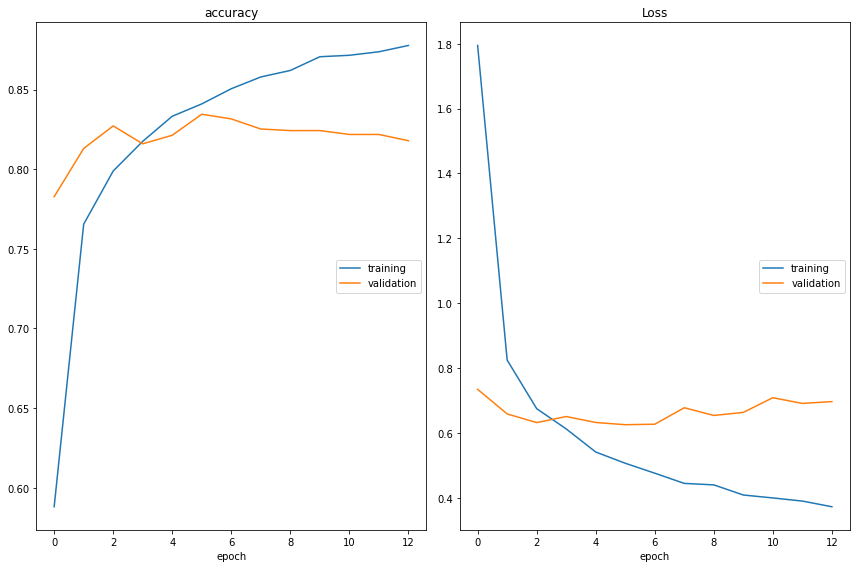

accuracy
	training         	 (min:    0.588, max:    0.878, cur:    0.878)
	validation       	 (min:    0.783, max:    0.834, cur:    0.818)
Loss
	training         	 (min:    0.372, max:    1.795, cur:    0.372)
	validation       	 (min:    0.625, max:    0.734, cur:    0.696)
513/513 [==============================] - 320s 624ms/step - loss: 0.3723 - accuracy: 0.8776 - val_loss: 0.6965 - val_accuracy: 0.8179
Epoch 13: early stopping


In [ ]:
### Training the model :

ViT_1.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) # with adam optimizer

epochs = 40


history = ViT_1.fit(train_generator,
                    steps_per_epoch = train_size // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps = val_size // batch_size,
                    callbacks=[checkpoint_cb_ViT2, early_stopping_cb_ViT2, plot_loss_cb_ViT2])

# Comparison with a ResNet-50 : 

In [16]:
### Batch generation with the correct preprocessing steps :

from tensorflow.keras.applications.resnet50 import preprocess_input 
# The images are converted from RGB to BGR, 
# then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.25,
                                   zoom_range=0.25,
                                   channel_shift_range=25,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    batch_size=batch_size,
                                                    target_size=(224, 224), # same as default for the ResNet-50 model
                                                    class_mode="categorical") 
                                                    # classes are automatically inferred from the subdirectory structure

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = validation_datagen.flow_from_directory(VALIDATION_PATH,
                                                       batch_size=batch_size,
                                                       target_size=(224, 224),
                                                       class_mode='categorical')

Found 16418 images belonging to 120 classes.
Found 2052 images belonging to 120 classes.


In [17]:
### Creating callbacks :

# Models path

ROOT_PATH = os.path.join('/content', 'drive/MyDrive/OpenClassroom/Projet 7')
MODELS_PATH = os.path.join(ROOT_PATH, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

FILE_PATH = MODELS_PATH + "/ResNet50.h5"


checkpoint_cb_ResNet50 = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                         monitor='val_accuracy',
                                                         verbose=1,
                                                         save_best_only=True,
                                                         mode='max')
from livelossplot import PlotLossesKeras
plot_loss_cb_ResNet50 = PlotLossesKeras()

early_stopping_cb_ResNet50 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=9,
                                                           mode='auto',
                                                           verbose=1,
                                                           restore_best_weights=True)

In [18]:
### Creating the ResNet50 model, pretrained on ImageNet :

# Definition of the pretrained ResNet50 model :
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False,
                      input_shape = (224,224,3),
                      weights = 'imagenet') # pretrained on ImageNet

# Freezing its layers weigth :
base_model.trainable = False

## Creating new FC layers to train on top of the base model :

nb_classes = 120

x1 = keras.layers.GlobalAveragePooling2D()(base_model.output)
x2 = keras.layers.Dropout(0.15)(x1)
predictions = keras.layers.Dense(nb_classes, activation = 'softmax')(x2)

ResNet50_model = keras.Model(inputs=base_model.input, outputs=predictions)

ResNet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

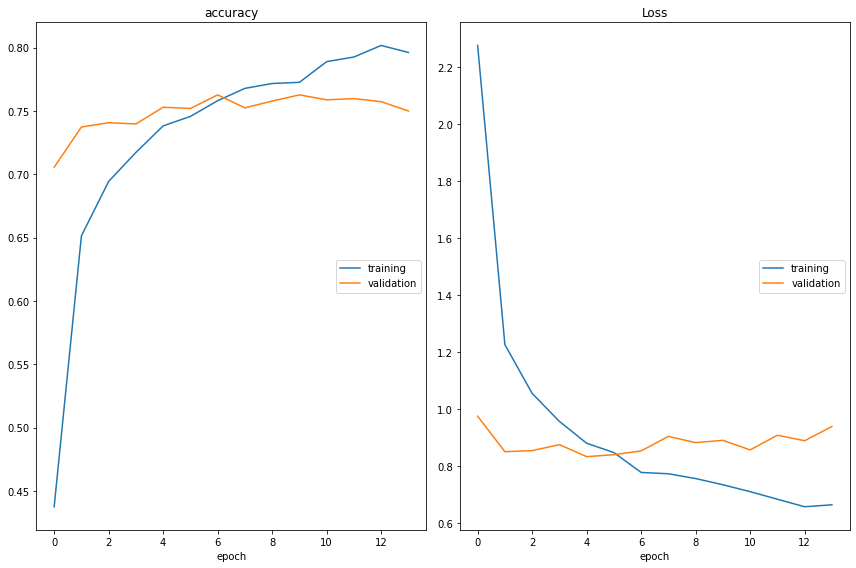

accuracy
	training         	 (min:    0.438, max:    0.802, cur:    0.796)
	validation       	 (min:    0.706, max:    0.763, cur:    0.750)
Loss
	training         	 (min:    0.658, max:    2.276, cur:    0.665)
	validation       	 (min:    0.834, max:    0.975, cur:    0.939)
Restoring model weights from the end of the best epoch: 5.
256/256 [==============================] - 230s 898ms/step - loss: 0.6647 - accuracy: 0.7962 - val_loss: 0.9394 - val_accuracy: 0.7500
Epoch 14: early stopping


In [19]:
### Training the final model :

ResNet50_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"]) # with adam optimizer

epochs = 40

history = ResNet50_model.fit(train_generator,
                             steps_per_epoch = train_size // batch_size,
                             epochs=epochs,
                             validation_data=val_generator,
                             validation_steps = val_size // batch_size,
                             callbacks=[checkpoint_cb_ResNet50, 
                                        plot_loss_cb_ResNet50, 
                                        early_stopping_cb_ResNet50])